In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import t
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import statistics
sns.set()

df = pd.read_csv(' Lot Data.csv')
df_2_300 = df[(df['Scale (L)'] == 300) & (df['Process'] == 2)]
df_2_30 = df[(df['Scale (L)'] == 30) & (df['Process'] == 2)]

def extract_columns_with_keywords(df, keywords):
    selected_columns = [col for col in df.columns if any(keyword in col.lower() for keyword in keywords)]
    df_selected = df[selected_columns]
    return df_selected

recovery_df_300 = extract_columns_with_keywords(df_2_300, ["recovery", "construct"])
recovery_df_30 = extract_columns_with_keywords(df_2_30, ["recovery", "construct"])

Creating Recovery Datasets

In [64]:
def preprocess_recovery_dataframe(df_name_1):
    # Drop the column 'MMC Recovery g'
    df_name = df_name_1.drop(labels='MMC Recovery g', axis=1)

    # Replace various representations of missing values with NaN only in 'recovery' columns
    recovery_columns = [col for col in df_name.columns if 'recovery' in col.lower()]
    missing_values = ['', 'NA', 'N/A', 'nan', 'null', 'None']  # Add any other representations you want to handle
    df_name[recovery_columns] = df_name[recovery_columns].replace(missing_values, np.nan)

    # Convert 'recovery' columns to numeric format and remove percentage sign
    for column in recovery_columns:
        df_name[column] = pd.to_numeric(df_name[column].str.replace('%', ''), errors='coerce')

    # Drop rows with any remaining NaN values after conversion to numeric in 'recovery' columns
    df_name.dropna(subset=recovery_columns, inplace=True)
    df_name.reset_index(drop=True, inplace=True)

    return df_name

In [65]:
recovery_df_300 = preprocess_recovery_dataframe(recovery_df_300)
recovery_df_30 = preprocess_recovery_dataframe(recovery_df_30)
recovery_df_30.to_csv(r'stuff.csv', index=False)
recovery_df_300.to_csv(r'results_300.csv', index=False)

In [66]:
def bootstrap_resample(data_frame, num_bootstrap_samples):
    # Get the column names for the numeric (float) columns
    float_columns = [col for col in data_frame.columns if data_frame[col].dtype == float]
    
    # Initialize an empty array to store bootstrap samples
    bootstrap_samples = np.empty((num_bootstrap_samples, len(float_columns)))
    
    # Perform bootstrap resampling
    for i in range(num_bootstrap_samples):
        # Randomly sample with replacement from the DataFrame for each numeric column
        bootstrap_sample = data_frame[float_columns].sample(n=len(data_frame), replace=True)
        
        # Compute some statistic on the bootstrap sample (e.g., mean, median, correlation, etc.)
        # For example, to calculate the mean of each column in the bootstrap sample:
        bootstrap_statistic = np.mean(bootstrap_sample, axis=0)
        
        # Store the statistic in the bootstrap_samples array
        bootstrap_samples[i] = bootstrap_statistic
    
    return pd.DataFrame(bootstrap_samples, columns=float_columns)

def bootstrap_string_column(data_frame, column_name, num_bootstrap_samples=1000):
    # Get the specified column
    column_data = data_frame[column_name]

    # Initialize an empty list to store bootstrap samples
    bootstrap_samples = []

    # Perform bootstrap resampling
    for i in range(num_bootstrap_samples):
        # Randomly sample with replacement from the column
        bootstrap_sample = np.random.choice(column_data, size=len(column_data), replace=True)
        
        # Append the bootstrap sample to the list
        bootstrap_samples.append(bootstrap_sample)

    return pd.DataFrame(bootstrap_samples)

In [67]:
#300
bootstrap_string_300 = bootstrap_string_column(recovery_df_300, 'Construct', num_bootstrap_samples=1000)
bootstrap_samples_df_300 = bootstrap_resample(recovery_df_300, num_bootstrap_samples=1000)
bootstrap_samples_df_300['Construct'] = bootstrap_string_300[0]

#30
bootstrap_string_30 = bootstrap_string_column(recovery_df_30, 'Construct', num_bootstrap_samples=1000)
bootstrap_samples_df_30 = bootstrap_resample(recovery_df_30, num_bootstrap_samples=1000)
bootstrap_samples_df_30['Construct'] = bootstrap_string_30[0]

Graphing the PCA Results

In [61]:
def graph(dataset, title):
    # Separating out the features
    features = [col for col in dataset.columns if col != 'Construct']

    # Separating out the features
    x = dataset.loc[:, features].values

    # Separating out the target
    y = dataset.loc[:,['Construct']].values

    # Standardizing the features
    x = StandardScaler().fit_transform(x)

    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

    finalDf = pd.concat([principalDf, dataset[['Construct']]], axis = 1)

    plt.figure(figsize=(8, 6))
    constructs = finalDf['Construct'].unique()
    for construct in constructs:
        x = finalDf.loc[finalDf['Construct'] == construct, 'principal component 1']
        y = finalDf.loc[finalDf['Construct'] == construct, 'principal component 2']
        plt.scatter(x, y, label=construct)

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(title)
    plt.xticks([-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8])
    plt.yticks([-5,-4,-3,-2,-1,0,1,2,3,4,5])
    plt.grid(True)
    plt.show()

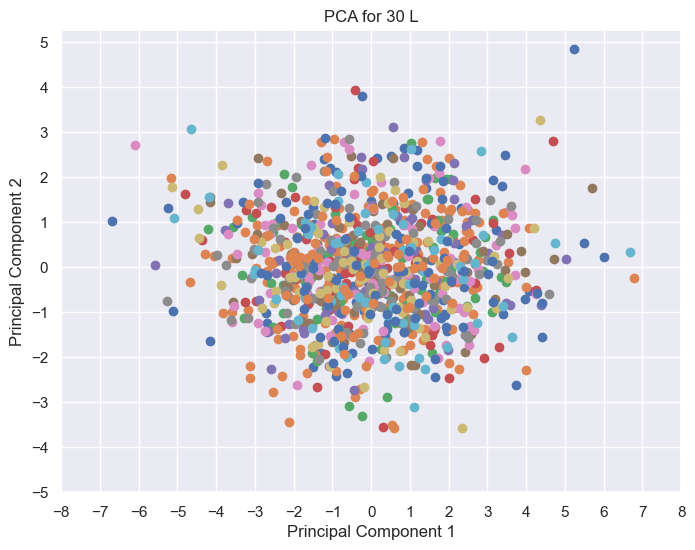

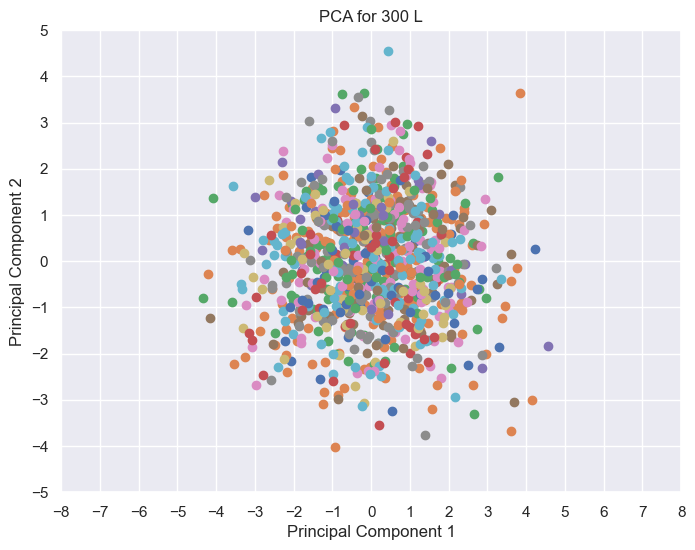

In [62]:
graph(bootstrap_samples_df_30, 'PCA for 30 L')
graph(bootstrap_samples_df_300, 'PCA for 300 L')